In [1]:
using Pkg
# Pkg.add("Plots")
# Pkg.add("DifferentialEquations")
# Pkg.add("LinearAlgebra")
# Pkg.add("SparseArrays")
# Pkg.add("PolygonOps")
# Pkg.add("DataFrames")
# Pkg.add("Makie")
# Pkg.add("ColorSchemes")
# Pkg.add("LibGEOS")
# Pkg.add("GeoInterface")
# Pkg.add("PlotlyJS")
# Pkg.add("GLMakie")
# Pkg.add("GeometryBasics")
# Pkg.add("GLM")

In [2]:
using Plots
using DifferentialEquations
using LinearAlgebra
using SparseArrays
using PolygonOps
using DataFrames
using ColorSchemes
using LibGEOS
using GeoInterface
using Arpack
using GLMakie
using GeometryBasics
using GLM

In [3]:
l = 4
L = 1
D = 1.5 # Fractal dimension

1.5

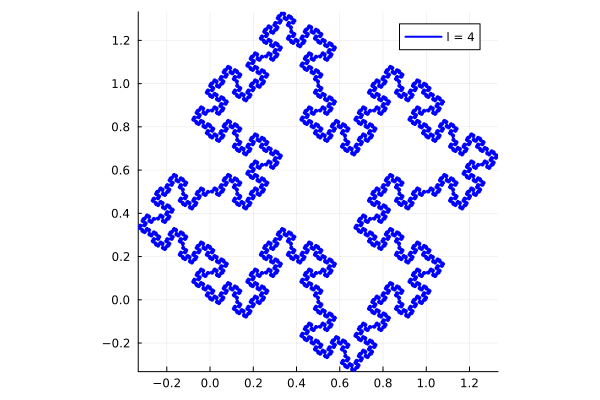

In [4]:
function koch_curve_iterative(l, L)
    # Initial line segment
    points = [[0.0, 0.0], [L, 0.0]]

    if l == 0
        return points
    end

    transform = [0.0 + 0.0im, 0.25 + 0im, 0.25 + 0.25im, 0.5 + 0.25im, 0.5 + 0.0im,
                 0.5 - 0.25im, 0.75 - 0.25im, 0.75 + 0im, 1 + 0im]

    for _ in 1:l
        new_points = ComplexF64[]

        for i in 1:length(points)-1
            p_i = points[i][1] + im*points[i][2]
            p_f = points[i+1][1] + im*points[i+1][2]
            segment = p_f - p_i

            append!(new_points, [(p_i + segment*p) for p in transform])
        end

        points = [[real(q), imag(q)] for q in new_points]
    end

    return points
end

function rotate_90deg(points)
    return [[-p[2], p[1]] for p in points]
end

function find_borders(vertices)

    x_min = minimum([p[1] for p in vertices])
    x_max = maximum([p[1] for p in vertices])
    y_min = minimum([p[2] for p in vertices])
    y_max = maximum([p[2] for p in vertices])

    return x_min, x_max, y_min, y_max
end

x_points1 = koch_curve_iterative(l, L)
y_points1 = rotate_90deg(koch_curve_iterative(l, L))
x_points2 = [[p[1], p[2] + L] for p in x_points1]
y_points2 = [[p[1] + L, p[2]] for p in y_points1]
vertices = vcat(x_points1, y_points2, reverse(x_points2), reverse(y_points1))
x_min, x_max, y_min, y_max = find_borders(vertices)

Plots.plot([p[1] for p in vertices], [p[2] for p in vertices], label="l = $l", linewidth=2, legend=true, 
            xlim=(x_min, x_max), ylim=(y_min, y_max), aspect_ratio=:equal, color=:blue)

In [5]:
function square_lattice(lmax, L)

    d = L/(4^lmax)
    d_arr = [L/4^l for l in 1:lmax]
    L_l = L + 2*sum(d_arr)
    N = round(Int, L_l/d)

    x_points1 = koch_curve_iterative(l, L)
    y_points1 = rotate_90deg(koch_curve_iterative(l, L))
    x_points2 = [[p[1], p[2] + L] for p in x_points1]
    y_points2 = [[p[1] + L, p[2]] for p in y_points1]

    square_grid = zeros(N+1, N+1)

    return square_grid, d, L_l
end

square_lattice (generic function with 1 method)

In [6]:
function ray_intersects_segment(origin, direction, p1, p2)
    
    v1 = origin .- p1
    v2 = p2 .- p1
    v3 = [-direction[2], direction[1]]

    dotproduct = dot(v2, v3)
    if abs(dotproduct) < 1e-6
        return false
    end

    w1 = dot(v1, v3)/dotproduct
    w2 = dot(v1, v2)/dotproduct

    if w1 >= 0 && w2 >= 0 && w2 <= 1
        return true
    end

    return false
end

function ray_cast(origin, direction, vertices)

    intersections = 0

    for i in 1:length(vertices)-1
        if ray_intersects_segment(origin, direction, vertices[i], vertices[i+1])
            intersections += 1
        end
    end

    return intersections
end


# function ray_casting(square_grid, d, x_points1, y_points1, x_points2, y_points2, x_min, y_min)

#     N = size(square_grid)[1]

#     vertices = vcat(x_points1, y_points1, x_points2, y_points2)
#     vertices = reverse(vertices)
#     # vertices = vcat(vertices, vertices[1, :])

#     A = 0
#     for i in 1:length(vertices)-1
#         x_i, y_i = vertices[i]
#         x_next, y_next = vertices[i+1]
#         A += 0.5*(x_i*y_next - x_next*y_i)
#     end

#     if A == 0
#         println("$A = 0 ==> vertices is not a valid closed shape.")
#     elseif A < 0
#         println("$A < 0 ==> vertices are clockwise, flip them.")
#     elseif A > 0
#         println("$A > 0 ==> vertices are counterclockwise, all good.")
#     end

#     epsilon = 1e-6

#     for i in 1:N
#         for j in 1:N

#             origin = [x_min + (i-1)*d, y_min + (j-1)*d]
#             direction = [0, 1 + epsilon]
#             # println(ray_cast(origin, direction, vertices))

#             if ray_cast(origin, direction, vertices) % 2 == 1
#                 square_grid[i, j] = 1
#             elseif origin in x_points1 || origin in y_points1 || origin in x_points2 || origin in y_points2
#                 square_grid[i, j] = 0
#             else
#                 square_grid[i, j] = -1
#             end
#         end
#     end

#     return square_grid
# end

function ray_casting(square_grid, d, vertices, x_min, y_min)

    N = size(square_grid)[1]
    
    # Ensure vertices form a closed, counterclockwise shape
    A = 1
    if A == 0
        for i in 1:length(vertices)-1
            x_i, y_i = vertices[i]
            x_next, y_next = vertices[i+1]
            A += 0.5*(x_i*y_next - x_next*y_i)
        end

        if A == 0
            println("$A = 0 ==> vertices is not a valid closed shape.")
        elseif A < 0
            println("$A < 0 ==> vertices are clockwise, flip them.")
        elseif A > 0
            println("$A > 0 ==> vertices are counterclockwise, all good.")
        end
    end

    # Small perturbation to avoid hitting vertices exactly
    epsilon = 1e-6

    for i in 1:N
        for j in 1:N
            origin = [x_min + (i-1) * d, y_min + (j-1) * d]
            direction = [0, 1 + epsilon]  # Slightly perturb to avoid exact vertex hits

            intersections = ray_cast(origin, direction, vertices)

            if intersections % 2 == 1
                square_grid[i, j] = 1  # Inside
            elseif any(isapprox(origin, v, atol=1e-6) for v in vertices)
                square_grid[i, j] = 0  # On a vertex
            else
                square_grid[i, j] = -1  # Outside
            end
        end
    end

    return square_grid
end

ray_casting (generic function with 1 method)

In [7]:
function classify_points_on_grid(square_grid, vertices, x_min, y_min, d)

    N = size(square_grid)[1]

    A = 1
    if A == 0
        for i in 1:length(vertices)-1
            x_i, y_i = vertices[i]
            x_next, y_next = vertices[i+1]
            A += 0.5*(x_i*y_next - x_next*y_i)
        end

        if A == 0
            println("$A = 0 ==> vertices is not a valid closed shape.")
        elseif A < 0
            println("$A < 0 ==> vertices are clockwise, flip them.")
        elseif A > 0
            println("$A > 0 ==> vertices are counterclockwise, all good.")
        end
    end

    # Total iterations for progress tracking
    total_iterations = N * N
    current_iteration = 0
    t = time()

    for i in 1:N
        for j in 1:N 
            point = [x_min + (i-1)*d, y_min + (j-1)*d]
            if inpolygon(point, vertices) == 1
                square_grid[i, j] = 1
            elseif inpolygon(point, vertices) == -1
                square_grid[i, j] = 0
            elseif inpolygon(point, vertices) == 0
                square_grid[i, j] = -1
            end
            current_iteration += 1
            # Print progress every 10% of iterations
            if current_iteration % (total_iterations ÷ 10) == 0
                println("Progress: $(round(100 * current_iteration / total_iterations, digits=1))%, time elapsed: $(round(time()-t, digits=1)) seconds.")
                t = time()
            end
        end
    end

    return square_grid
end

classify_points_on_grid (generic function with 1 method)

In [8]:
function check_if_point_within_polygon(vertices_geom, point_geom)

    if LibGEOS.within(point_geom, vertices_geom)
        return true
    end

    return false
end

function update_square_grid_using_within(square_grid, x_points1, y_points1, x_points2, y_points2, x_min, y_min, d)

    N = size(square_grid)[1]

    vertices = vcat([(p[1], p[2]) for p in x_points1], [(p[1], p[2]) for p in y_points2], [(p[1], p[2]) for p in reverse(x_points2)], [(p[1], p[2]) for p in reverse(y_points1)])
    # vertices = vcat(vertices, [vertices[1]])

    A = 1
    if A == 0
        for i in 1:length(vertices)-1
            x_i, y_i = vertices[i]
            x_next, y_next = vertices[i+1]
            A += 0.5*(x_i*y_next - x_next*y_i)
        end

        if A == 0
            println("$A = 0 ==> vertices is not a valid closed shape.")
        elseif A < 0
            println("$A < 0 ==> vertices are clockwise, flip them.")
        elseif A > 0
            println("$A > 0 ==> vertices are counterclockwise, all good.")
        end
    end

    vertices_geom = LibGEOS.readgeom("POLYGON((" * join([string(p[1]) * " " * string(p[2]) for p in vcat(vertices, [vertices[1]])], ", ") * "))")
    
    # Total iterations for progress tracking
    total_iterations = N * N
    current_iteration = 0
    t = time()

    for i in 1:N
        for j in 1:N
            point = [x_min + (i-1)*d, y_min + (j-1)*d]
            point_geom = LibGEOS.readgeom("POINT($(point[1]) $(point[2]))")
            if check_if_point_within_polygon(vertices_geom, point_geom)
                square_grid[i, j] = 1
            elseif point in x_points1 || point in y_points1 || point in x_points2 || point in y_points2
                square_grid[i, j] = 0
            else
                square_grid[i, j] = -1
            end
            current_iteration += 1
            # Print progress every 10% of iterations
            if current_iteration % (total_iterations ÷ 10) == 0
                println("Progress: $(round(100 * current_iteration / total_iterations, digits=1))%, time elapsed: $(round(time()-t, digits=1)) seconds.")
                t = time()
            end
        end
    end

    return square_grid
end

update_square_grid_using_within (generic function with 1 method)

In [9]:
function sum_angles(point, vertices)

    anglesum = 0

    for i in length(vertices)-1
        v1 = vertices[i] .- point
        v2 = vertices[i+1] .-point
        costheta = 0
        if norm(v1) == 0 || norm(v2) == 0
            continue
        else
            dot_product = dot(v1, v2)
            costheta = clamp(dot_product / (norm(v1) * norm(v2)), -1, 1)
            anglesum += atan(costheta)
        end
    end

    return anglesum
end

function update_square_grid(square_grid, vertices, x_min, y_min)

    N = size(square_grid)[1]

    A = 1
    if A == 0
        for i in 1:length(vertices)-1
            x_i, y_i = vertices[i]
            x_next, y_next = vertices[i+1]
            A += 0.5*(x_i*y_next - x_next*y_i)
        end

        if A == 0
            println("$A = 0 ==> vertices is not a valid closed shape.")
        elseif A < 0
            println("$A < 0 ==> vertices are clockwise, flip them.")
        elseif A > 0
            println("$A > 0 ==> vertices are counterclockwise, all good.")
        end
    end

    tol=1e-6

    for i in 1:N
        for j in 1:N
            point = [x_min + (i-1)*d, y_min + (j-1)*d]
            anglesum = sum_angles(point, vertices)
            winding_number = anglesum/(2*pi)
            if point in x_points1 || point in y_points1 || point in x_points2 || point in y_points2
                square_grid[i, j] = 0
            elseif winding_number%2 == 1
                square_grid[i, j] = 1
            else
                square_grid[i, j] = -1
            end
        end
    end

    return square_grid
end

update_square_grid (generic function with 1 method)

In [10]:
function winding_number_algorithm(point, vertices)
    
    x, y = point 
    wn = 0 # winding number

    for i in 1:length(vertices)
        x_i, y_i = vertices[i]
        x_next, y_next = vertices[mod1(i+1, length(vertices))]

        if y_i <= y < y_next # crossing upwards
            if (x_next - x_i)*(y - y_i) - (y_next - y_i)*(x - x_i) > 0
                wn += 1
            end
        elseif y_next <= y < y_i # crossing downwards
            if (x_next - x_i)*(y - y_i) - (y_next - y_i)*(x - x_i) < 0
                wn -= 1
            end
        end
    end

    return wn
end

function winding_number_grid(square_grid, vertices, x_min, y_min, d)

    N = size(square_grid)[1]

    A = 1
    if A == 0
        for i in 1:length(vertices)-1
            x_i, y_i = vertices[i]
            x_next, y_next = vertices[i+1]
            A += 0.5*(x_i*y_next - x_next*y_i)
        end

        if A == 0
            println("$A = 0 ==> vertices is not a valid closed shape.")
        elseif A < 0
            println("$A < 0 ==> vertices are clockwise, flip them.")
        elseif A > 0
            println("$A > 0 ==> vertices are counterclockwise, all good.")
        end
    end

    # for i in 1:N
    #     for j in 1:N
    #         point = [x_min + (i-1)*d, y_min + (j-1)*d]
    #         wn = winding_number_algorithm(point, vertices)

    #         if any(p -> norm(point - p) < 1e-8, vcat(x_points1, y_points1, x_points2, y_points2))
    #             square_grid[i,j] = 0
    #         elseif wn != 0
    #             square_grid[i,j] = 1
    #         else
    #             square_grid[i,j] = -1
    #         end
    #     end
    # end

    # Vectorized grid points (x and y)
    x_grid = x_min .+ (0:N-1) * d
    y_grid = y_min .+ (0:N-1) * d
    points = [(x, y) for x in x_grid, y in y_grid]

    # Total iterations for progress tracking
    total_iterations = N * N
    current_iteration = 0
    t = time()

    # Iterate over points and compute winding numbers
    for (i, point) in enumerate(points)
        wn = winding_number_algorithm(point, vertices)

        # Extract grid coordinates
        i, j = divrem(i-1, N)

        # Check if the point exists in any of the predefined sets
        if (point[1], point[2]) in vertices
            square_grid[i+1, j+1] = 0
        elseif wn != 0
            square_grid[i+1, j+1] = 1
        else
            square_grid[i+1, j+1] = -1
        end
        
        current_iteration += 1
        # Print progress every 10% of iterations
        if current_iteration % (total_iterations ÷ 10) == 0
            println("Progress: $(round(100 * current_iteration / total_iterations, digits=1))%, time elapsed: $(round(time()-t, digits=1)) seconds.")
            t = time()
        end
    end

    return square_grid
end

winding_number_grid (generic function with 1 method)

In [11]:
function plot_square_grid(square_grid, vertices, x_min, x_max, y_min, y_max)

    xs = range(x_min, x_max, length=size(square_grid)[1])
    ys = range(y_min, y_max, length=size(square_grid)[1])

    Plots.heatmap(xs, ys, square_grid', title="Winding Number Heatmap", color=:cool, xlim=(x_min, x_max), 
                  ylim=(y_min, y_max), xlabel="x/L", ylabel="y/L", aspect_ratio=:equal)
    Plots.plot!([p[1] for p in vertices], [p[2] for p in vertices], label="l = $l", linewidth=2, legend=true, 
                  xlim=(x_min, x_max), ylim=(y_min, y_max), aspect_ratio=:equal, color=:black)
    display(current())
end

plot_square_grid (generic function with 1 method)

In [12]:
if false # Does not work, raycasting method
        t1 = time()
        square_grid1, d, L_l = square_lattice(l, L)
        square_grid1 = ray_casting(square_grid1, d, vertices, x_min, y_min)
        println("The raycasting method took $(round(time() - t1, digits=1)) seconds")
end

if true # Works, inpolygon method, ~10 seconds for l=4
        t2 = time()
        square_grid2, d, L_l = square_lattice(l, L)
        square_grid2 = classify_points_on_grid(square_grid2, vertices, x_min, y_min, d)
        println("The inpolygon method took $(round(time() - t2, digits=1)) seconds")
end

if false # Works, within method, ~10 seconds for l=4
        t4 = time()
        square_grid4, d, L_l = square_lattice(l, L)
        square_grid4 = update_square_grid_using_within(square_grid4, x_points1, y_points1, x_points2, y_points2, x_min, y_min, d)
        println("The within method took $(round(time() - t4, digits=1)) seconds")
end

if false # Does not work, anglesum_method
        t5 = time()
        square_grid5, d, L_l = square_lattice(l, L)
        square_grid5 = update_square_grid(square_grid5, vertices, x_min, y_min)
        println("The anglesum method took $(round(time() - t5, digits=1)) seconds")
end

if false # Works, winding number method, ~12 seconds for l=4
        t6 = time()
        square_grid6, d, L_l = square_lattice(l, L)
        square_grid6 = winding_number_grid(square_grid6, vertices, x_min, y_min, d)
        println("The winding number method took $(round(time() - t6, digits=1)) seconds")
end

ifplot = "haha nei"
if ifplot == true
        plot_square_grid(square_grid5', vertices, x_min, x_max, y_min, y_max)
end

Progress: 10.0%, time elapsed: 1.9 seconds.
Progress: 20.0%, time elapsed: 2.4 seconds.
Progress: 30.0%, time elapsed: 1.3 seconds.
Progress: 40.0%, time elapsed: 0.9 seconds.
Progress: 50.0%, time elapsed: 1.2 seconds.
Progress: 60.0%, time elapsed: 1.0 seconds.
Progress: 70.0%, time elapsed: 1.2 seconds.
Progress: 80.0%, time elapsed: 1.5 seconds.
Progress: 90.0%, time elapsed: 2.0 seconds.
Progress: 100.0%, time elapsed: 2.9 seconds.
The inpolygon method took 16.5 seconds


In [13]:
# println("x_points1: first = $(x_points1[1]), last = $(x_points1[end])")
# println("y_points2: first = $(y_points2[1]), last = $(y_points2[end])")
# println("x_points2: first = $(reverse(x_points2)[1]), last = $(reverse(x_points2)[end])")
# println("y_points1: first = $(reverse(y_points1)[1]), last = $(reverse(y_points1)[end])")

Helmholtz equation:

\begin{equation}
    -\nabla^2U(\mathbf{x}, \omega) = \frac{\omega^2}{v^2}U(\mathbf{x}, \omega)
\end{equation}

Using a standard (5-point) central finite difference approximation for the Laplacian in the Helmholtz equation gives

\begin{equation}
    -\frac{1}{d^2}\left[U_{m+1,n} + U_{m-1,n} + U_{m, n+1} + U_{m,n-1} -4U_{mn} \right] = \frac{\omega^2}{c^2}U_{mn}.
\end{equation}

Where $d$ is the lattice constant of the square lattice, $U$ denotes vertical displacement, $\omega$ is the eigenfrequency of the drum and $c$ is a velocity.

\begin{equation}
    \left(\frac{4}{d^2} + \frac{\omega^2}{c^2} \right) U_{mn} - \left(U_{m+1,n} + U_{m-1,n} + U_{m, n+1} + U_{m,n-1} \right) = 0.
\end{equation}

By letting $\displaystyle\Omega = \frac{\omega}{c}L$, and multiplying both sides by $L^2$, we get

\begin{equation}
    \left(4N^2 + \Omega^2 \right) U_{mn} - L^2\left(U_{m+1,n} + U_{m-1,n} + U_{m, n+1} + U_{m,n-1} \right) = 0.
\end{equation}

In [14]:
function helmholtz_solver(square_grid, l)

    N = size(square_grid)[1]
    classification_matrix = zeros(Int, N, N)
    p = 1

    for i in 1:N
        for j in 1:N
            if square_grid[i, j] > 0
                classification_matrix[i, j] = p
                p += 1
            end
        end
    end

    num_internal_points = p-1
    I, J, V = Int[], Int[], Float64[]
    
    # Total iterations for progress tracking
    total_iterations = N * N
    current_iteration = 0
    t = time()

    for j in 1:N
        for i in 1:N

            p = classification_matrix[i, j]

            if p > 0
                push!(I, p)
                push!(J, p)
                push!(V, 4^(l+1))

                neighbors = [(i+1, j), (i-1, j), (i, j+1), (i, j-1)]
                for (m, n) in neighbors
                    if 1 <= m <= N && 1 <= n <= N
                        q = classification_matrix[m, n]
                        if q > 0
                            push!(I, p)
                            push!(J, q)
                            push!(V, -4^l)
                        end
                    end
                end
            end
            current_iteration += 1
            # Print progress every 10% of iterations
            if current_iteration % (total_iterations ÷ 10) == 0
                println("Progress: $(round(100 * current_iteration / total_iterations, digits=1))%, time elapsed: $(round(time()-t, digits=1)) seconds.")
                t = time()
            end
        end
    end

    A = sparse(I, J, V, num_internal_points, num_internal_points)
    
    eigen_modes, eigen_vecs = eigs(A; nev=40, which=:SM, maxiter=1000, tol=1e-8)

    return eigen_modes, eigen_vecs, classification_matrix, A
end

function map_modes_vec_onto_grid(classification_matrix, eigen_vecs, l)
    N = size(classification_matrix)[1]
    num_modes = size(eigen_vecs)[2]
    
    # Check if the array size is too large
    if N * N * num_modes > 1e8  # Adjust this threshold based on your system's memory capacity
        error("Array size is too large to fit in memory")
    end
    
    modes = zeros(ComplexF64, N, N, num_modes)
    
    for i in 1:N
        for j in 1:N
            if classification_matrix[i, j] > 0
                p = classification_matrix[i, j]
                for k in 1:num_modes
                    modes[i, j, k] = eigen_vecs[p, k]
                end
            end
        end
    end
    
    return modes
end

map_modes_vec_onto_grid (generic function with 1 method)

In [15]:
# Compute the dimensionless fundamental eigenfrequency of the classic square drum
fundamental_freq = sqrt(2π)

if isdefined(Main, :square_grid1) # Check if ray-casting method has been calculated for the square grid

    t1 = time()
    # Solve system
    eigen_modes1, eigen_vecs1, classification_matrix1, A1 = helmholtz_solver(square_grid1, l)
    println("Solving Helmholtz equation for raycasting grid took $(round(time() - t1, digits=1)) seconds.")

    # Create dataframe for storage
    results1 = DataFrame(mode_number = Int[], eigen_frequency = Float64[], degeneracy = Int[], frequency_ratio = Float64[])

    # Sort the eigenvalues and identify the degree of degeneracy
    sorted_indices1 = sortperm(real(eigen_modes1))
    sorted_eigenvalues1 = real(eigen_modes1[sorted_indices1])
    unique_eigenvalues1 = unique(sorted_eigenvalues1)
    sorted_eigen_vecs1 = eigen_vecs1[:, sorted_indices1]

    # Update the dataframe
    for (i, eigen_freq) in enumerate(unique_eigenvalues1)
        g_nu = count(x -> round(x,digits=6) == round(eigen_freq, digits=6), sorted_eigenvalues1)
        freq_ratio = eigen_freq / fundamental_freq
        push!(results1, (i-1, eigen_freq, g_nu, freq_ratio))
    end

    println() 

    # Map the eigenmodes onto the square grid for plotting
    modes1 = map_modes_vec_onto_grid(classification_matrix1, sorted_eigen_vecs1, l)
end

if isdefined(Main, :square_grid2) # Check if inpolygon method has been calculated for the square grid

    # Solve system
    t2 = time()
    eigen_modes2, eigen_vecs2, classification_matrix2, A2 = helmholtz_solver(square_grid2, l)
    println("Solving Helmholtz equation for inpolygon grid took $(round(time() - t2, digits=1)) seconds.")

    # Create dataframe for storage
    results2 = DataFrame(mode_number = Int[], eigen_frequency = Float64[], degeneracy = Int[], frequency_ratio = Float64[])

    # Sort the eigenvalues and identify the degree of degeneracy
    sorted_indices2 = sortperm(real(eigen_modes2))
    sorted_eigenvalues2 = real(eigen_modes2[sorted_indices2])
    unique_eigenvalues2 = unique(sorted_eigenvalues2)
    sorted_eigen_vecs2 = eigen_vecs2[:, sorted_indices2]

    # Update the dataframe
    for (i, eigen_freq) in enumerate(unique_eigenvalues2)
        g_nu = count(x -> round(x,digits=6) == round(eigen_freq, digits=6), sorted_eigenvalues2)
        freq_ratio = eigen_freq / fundamental_freq
        push!(results2, (i-1, eigen_freq, g_nu, freq_ratio))
    end

    println(results2) 

    # Map the eigenmodes onto the square grid for plotting
    modes2 = map_modes_vec_onto_grid(classification_matrix2, sorted_eigen_vecs2, l)
end

if isdefined(Main, :square_grid4) # Check if within method has been calculated for the square grid

    # Solve system
    t4 = time()
    eigen_modes4, eigen_vecs4, classification_matrix4, A4 = helmholtz_solver(square_grid4, l)
    println("Solving Helmholtz equation for within grid took $(round(time() - t4, digits=1)) seconds.")

    # Create dataframe for storage
    results4 = DataFrame(mode_number = Int[], eigen_frequency = Float64[], degeneracy = Int[], frequency_ratio = Float64[])

    # Sort the eigenvalues and identify the degree of degeneracy
    sorted_indices4 = sortperm(real(eigen_modes4))
    sorted_eigenvalues4 = real(eigen_modes4[sorted_indices4])
    unique_eigenvalues4 = unique(sorted_eigenvalues4)
    sorted_eigen_vecs4 = eigen_vecs4[:, sorted_indices4]

    # Update the dataframe
    for (i, eigen_freq) in enumerate(unique_eigenvalues4)
        g_nu = count(x -> round(x,digits=6) == round(eigen_freq, digits=6), sorted_eigenvalues4)
        freq_ratio = eigen_freq / fundamental_freq
        push!(results4, (i-1, eigen_freq, g_nu, freq_ratio))
    end

    println(results4)

    # Map the eigenmodes onto the square grid for plotting
    modes4 = map_modes_vec_onto_grid(classification_matrix4, sorted_eigen_vecs4, l)
end

if isdefined(Main, :square_grid5) # Check if anglesum method has been calculated for the square grid

    # Solve system
    t5 = time()
    eigen_modes5, eigen_vecs5, classification_matrix5, A5 = helmholtz_solver(square_grid5, l)
    println("Solving Helmholtz equation for anglesum grid took $(round(time() - t5, digits=1)) seconds.")

    # Create dataframe for storage
    results5 = DataFrame(mode_number = Int[], eigen_frequency = Float64[], degeneracy = Int[], frequency_ratio = Float64[])

    # Sort the eigenvalues and identify the degree of degeneracy
    sorted_indices5 = sortperm(real(eigen_modes5))
    sorted_eigenvalues5 = real(eigen_modes5[sorted_indices5])
    unique_eigenvalues5 = unique(sorted_eigenvalues5)
    sorted_eigen_vecs5 = eigen_vecs5[:, sorted_indices5] 

    # Update the dataframe
    for (i, eigen_freq) in enumerate(unique_eigenvalues5)
        g_nu = count(x -> round(x,digits=6) == round(eigen_freq, digits=6), sorted_eigenvalues5)
        freq_ratio = eigen_freq / fundamental_freq
        push!(results5, (i-1, eigen_freq, g_nu, freq_ratio))
    end

    println(results5[1:16,:])

    # Map the eigenmodes onto the square grid for plotting
    modes5 = map_modes_vec_onto_grid(classification_matrix5, sorted_eigen_vecs5, l)
end

if isdefined(Main, :square_grid6) # Check if winding number method has been calculated for the square grid

    # Solve system
    t6 = time()
    eigen_modes6, eigen_vecs6, classification_matrix6, A6 = helmholtz_solver(square_grid6, l)
    println("Solving Helmholtz equation for winding number grid took $(round(time() - t6, digits=1)) seconds.")

    # Create dataframe for storage
    results6 = DataFrame(mode_number = Int[], eigen_frequency = Float64[], degeneracy = Int[], frequency_ratio = Float64[])

    # Sort the eigenvalues and identify the degree of degeneracy
    sorted_indices6 = sortperm(real(eigen_modes6))
    sorted_eigenvalues6 = real(eigen_modes6[sorted_indices6])
    unique_eigenvalues6 = unique(sorted_eigenvalues6)
    sorted_eigen_vecs6 = eigen_vecs6[:, sorted_indices6] 

    # Update the dataframe
    for (i, eigen_freq) in enumerate(unique_eigenvalues6)
        g_nu = count(x -> round(x,digits=6) == round(eigen_freq, digits=6), sorted_eigenvalues6)
        freq_ratio = eigen_freq / fundamental_freq
        push!(results6, (i-1, eigen_freq, g_nu, freq_ratio))
    end

    println(results6)

    # Map the eigenmodes onto the square grid for plotting
    modes6 = map_modes_vec_onto_grid(classification_matrix6, sorted_eigen_vecs6, l)
end

Progress: 10.0%, time elapsed: 0.0 seconds.
Progress: 20.0%, time elapsed: 0.0 seconds.
Progress: 30.0%, time elapsed: 0.0 seconds.
Progress: 40.0%, time elapsed: 0.0 seconds.
Progress: 50.0%, time elapsed: 0.0 seconds.
Progress: 60.0%, time elapsed: 0.0 seconds.
Progress: 70.0%, time elapsed: 0.0 seconds.
Progress: 80.0%, time elapsed: 0.0 seconds.
Progress: 90.0%, time elapsed: 0.0 seconds.
Progress: 100.0%, time elapsed: 0.0 seconds.
Solving Helmholtz equation for inpolygon grid took 15.4 seconds.
40×4 DataFrame
 Row │ mode_number  eigen_frequency  degeneracy  frequency_ratio 
     │ Int64        Float64          Int64       Float64         
─────┼───────────────────────────────────────────────────────────
   1 │           0         0.347358           1         0.138576
   2 │           1         0.781776           2         0.311883
   3 │           2         0.781776           2         0.311883
   4 │           3         0.81224            1         0.324037
   5 │           4   

In [16]:
function plot_modes_2d_heatmap(square_grid, modes, k, vertices=vertices, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)

    x = LinRange(y_min, y_max, size(square_grid, 1)) # Create x- and y-axes
    y = LinRange(y_min, y_max, size(square_grid, 2))
    
    fig = Plots.heatmap(x, y, real(modes[:, :, k])', colormap=:balance, xlim=(x_min, x_max), ylim=(y_min, y_max), xlabel="x/L", ylabel="y/L", 
                  aspect_ratio=:equal, clims=(-maximum(abs, real(modes[:, :, k])), maximum(abs, real(modes[:, :, k]))))
    Plots.plot!([p[1] for p in vertices], [p[2] for p in vertices], label="l = $l, k = $k", linewidth=1, linealpha=0.4, legend=true, color=:black)
    
    save("heatmap_plot_l=$(l)_k=$(k).png", fig)

    # display(current())
end

# GLMakie.inline!(true)
function plot_modes_wireframe(square_grid, modes, k, add_surface=true, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)

    x = LinRange(y_min, y_max, size(square_grid, 1)) # Create x- and y-axes
    y = LinRange(y_min, y_max, size(square_grid, 2))
    
    z = real(modes[:, :, k]) 
    z[square_grid .<= 0] .= NaN # Logic, to only plot points inside of the fractal shape
    
    z_max = maximum([z for z in z if isfinite(z)]) # find max and min to adjust z-axis
    z_min = minimum([z for z in z if isfinite(z)])
    
    indexing = 1:6:length(x) # Add indexing to visualize the grid better
    
    fig = Figure() # Plot wireframe
    ax = Axis3(fig[1, 1], limits=(x_min, x_max, y_min, y_max, 2*z_min, 2*z_max), azimuth=pi/3, elevation=2*pi/15)
    
    GLMakie.wireframe!(ax, x[indexing], y[indexing], z[indexing, indexing], 
                        color=:black, transparency=true, linewidth=0.2, linestyle=(:solid, :loose))

    text!(ax, "l = $l, k = $k", color=:black, position=(x_max - 0.05*x_max, y_min, z_min))

    if add_surface == true
        GLMakie.surface!(ax, x, y, z, colormap=:cool, transparency=true, alpha=0.5)
        Colorbar(fig[1, 2], limits=(z_min, z_max), colormap=:cool)
    end
    save("wireframe_plot_l=$(l)_k=$(k).png", fig)
end

plot_modes_wireframe (generic function with 6 methods)

In [17]:
for k in 1:40
    plot_modes_wireframe(square_grid2, modes2, k)
end

In [18]:
for k in 1:40
    plot_modes_2d_heatmap(square_grid2, modes2, k)
end

Model Summary:
StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}
30×2 DataFrame
 Row │ log_Delta_N  log_omega 
     │ Float64      Float64   
─────┼────────────────────────
   1 │    0.908257  -1.0574
   2 │    1.71947   -0.246187
   3 │    1.7577    -0.207959
   4 │    1.76834   -0.197313
   5 │    1.84753   -0.118121
   6 │    2.16262    0.19696
   7 │    2.3        0.334347
   8 │    2.35682    0.391168
   9 │    2.41404    0.448384
  10 │    2.47079    0.505132
  11 │    2.54205    0.576393
  12 │    2.5692     0.603546
  13 │    2.71926    0.753606
  14 │    2.74133    0.775676
  15 │    2.84825    0.88259
  16 │    2.91543    0.949774
  17 │    2.91978    0.954127
  18 │    2.95116    0.985503
  19 │    3.066      1.10034
  20 │    3.07381    1.10816
  21 │    3.11       1.14434
  22 │    3.12123    1.15557
  23 │    3.12273    1.15707
  24 │    3.13204 

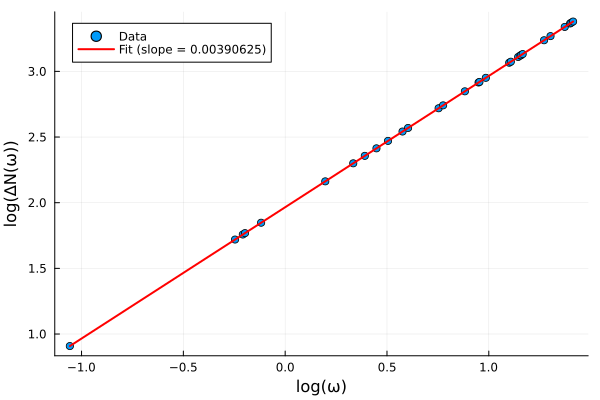

: 

In [ ]:
# function N_of_omega(eigen_freq, fundamental_freq=fundamental_freq, vertices=vertices, d=d, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)
#     return fundamental_freq*(x_max - x_min)*(y_max - y_min)*eigen_freq.^2/(4*pi) .- length(vertices)*d*eigen_freq/(4*pi)
# end

# function Delta_N_of_omega(eigen_freq, vertices=vertices, d=d, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)
#     return 0.5 * (x_max - x_min)*(y_max - y_min)*eigen_freq.^2 .- N_of_omega(eigen_freq)  
# end
using Statistics

function Delta_N_of_omega(eigen_freq, vertices=vertices, d=d, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)
    S = (x_max - x_min)*(y_max - y_min)
    L = length(vertices)*d
    return L*eigen_freq/(4*pi)
end

copy_results2 = deepcopy(results2)  # Reset data
D = NaN  # Reset D to ensure it's recalculated

# Recompute frequency-related data
unique_freq = unique(round.(copy_results2.eigen_frequency, digits=8))  # Ensure consistency
log_Delta_N = log.(round.(Delta_N_of_omega(unique_freq), digits=8))  # FIXED: Using unique_freq
log_omega = log.(unique_freq)

# Recreate DataFrame
Weyl_Berry_data = DataFrame(log_Delta_N=log_Delta_N, log_omega=log_omega)
model = lm(@formula(log_Delta_N ~ log_omega), Weyl_Berry_data)

println("Model Summary:")
println(summary(model))

println(Weyl_Berry_data)

println("Coefficients: ", coef(model))
println("R-squared: ", r2(model))

D = coef(model)[2]
C = coef(model)[1]

Plots.scatter(Weyl_Berry_data.log_omega, Weyl_Berry_data.log_Delta_N, label="Data", xlabel="log(ω)", ylabel="log(∆N(ω))")
Plots.plot!(Weyl_Berry_data.log_omega, D*Weyl_Berry_data.log_omega .+ C, label="Fit (slope = $d)", linewidth=2, color=:red)
display(current())

The value of D is: 2.6041873901003094


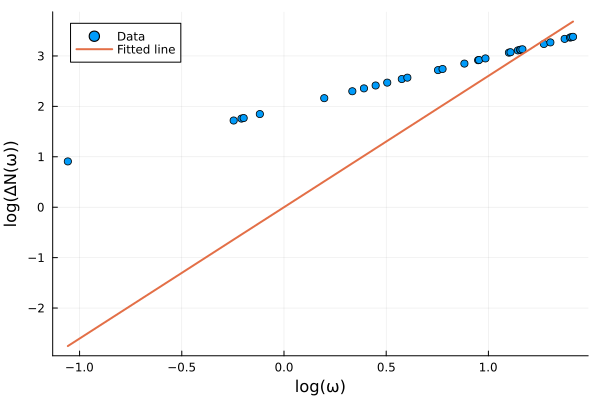

In [20]:
function Delta_N_of_omega2(eigen_freq, vertices=vertices, d=d, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)
    S = (x_max - x_min)*(y_max - y_min)
    L = length(vertices)*d
    return L*eigen_freq/(4*pi)
end

# Fit a linear model to log(Delta_N) vs log(unique_eigen_freq)
copy_results2_2 = deepcopy(results2)  # Reset data
D = NaN  # Reset D to ensure it's recalculated

unique_freq2 = unique(round.(copy_results2.eigen_frequency, digits=8))  # Ensure consistency
log_omega2 = log.(unique_freq2)
log_Delta_N2 = log.(Delta_N_of_omega2.(unique_freq2))
Delta_N_of_omega.(unique_freq2)

# Solve for coefficients (slope and intercept)
coefficients2 = log_omega2 \ log_Delta_N2

# The slope (D) is the first element of the coefficients vector
D = coefficients2

# Print the result
println("The value of D is: ", D)

# Optionally, you can plot the data and the fitted line
Plots.scatter(log_omega2, log_Delta_N2, label="Data", xlabel="log(ω)", ylabel="log(∆N(ω))")
Plots.plot!(log_omega2, log_omega2 * coefficients2, label="Fitted line", lw=2)

In [21]:
println(results2)

40×4 DataFrame
 Row │ mode_number  eigen_frequency  degeneracy  frequency_ratio 
     │ Int64        Float64          Int64       Float64         
─────┼───────────────────────────────────────────────────────────
   1 │           0         0.347358           1         0.138576
   2 │           1         0.781776           2         0.311883
   3 │           2         0.781776           2         0.311883
   4 │           3         0.81224            1         0.324037
   5 │           4         0.820933           1         0.327505
   6 │           5         0.888589           2         0.354496
   7 │           6         0.888589           2         0.354496
   8 │           7         1.2177             1         0.48579
   9 │           8         1.39703            1         0.557334
  10 │           9         1.47871            2         0.589919
  11 │          10         1.47871            2         0.589919
  12 │          11         1.56578            1         0.624656
  13 │  

In [22]:
println(results4)

LoadError: UndefVarError: `results4` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [ ]:
println(results6)